<a href="https://colab.research.google.com/github/DiyaSingla1012/Sampling/blob/main/sampling_assgn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install imbalanced-learn

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTETomek

In [3]:

# Upload dataset in Colab (Files > Upload OR run this cell)
try:
    from google.colab import files
    uploaded = files.upload()  # upload Creditcard_data.csv
    csv_name = next(iter(uploaded))  # first uploaded file name
    df = pd.read_csv(csv_name)
except Exception:
    # Fallback: load from assignment GitHub (raw)
    url="https://raw.githubusercontent.com/AnjulaMehto/Sampling_Assignment/main/Creditcard_data.csv"
    df = pd.read_csv(url)

target_candidates=["Class","class","target","Target","label","Label","fraud","Fraud"]
target_col=next((c for c in target_candidates if c in df.columns),df.columns[-1])

X=df.drop(columns=[target_col])
y=df[target_col]

Saving Creditcard_data.csv to Creditcard_data.csv


In [4]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=42,stratify=y)
balancer=RandomOverSampler(random_state=42)
X_train_bal,y_train_bal=balancer.fit_resample(X_train,y_train)
train_bal_df=pd.concat([X_train_bal,pd.Series(y_train_bal,name=target_col)],axis=1)
SAMPLE_SIZE=min(5000,len(train_bal_df))
seeds=[11,22,33,44,55]
samples=[train_bal_df.sample(n=SAMPLE_SIZE,random_state=s,replace=False).reset_index(drop=True) for s in seeds]


In [5]:
samplers={
"Sampling1_RandomOverSampler":RandomOverSampler(random_state=42),
"Sampling2_RandomUnderSampler":RandomUnderSampler(random_state=42),
"Sampling3_SMOTE":SMOTE(random_state=42),
"Sampling4_ADASYN":ADASYN(random_state=42),
"Sampling5_SMOTETomek":SMOTETomek(random_state=42)
}

In [6]:
models={
"M1_LogisticRegression":LogisticRegression(max_iter=2000),
"M2_RandomForest":RandomForestClassifier(n_estimators=200,random_state=42),
"M3_DecisionTree":DecisionTreeClassifier(random_state=42),
"M4_NaiveBayes":GaussianNB(),
"M5_SVM":SVC(kernel="rbf",probability=True,random_state=42)
}

def get_acc(Xtr,ytr,Xte,yte,model):
    pipe=Pipeline([("scaler",StandardScaler()),("clf",model)])
    pipe.fit(Xtr,ytr)
    return accuracy_score(yte,pipe.predict(Xte))

In [7]:
rows=[]
for i,samp in enumerate(samples,1):
    Xs=samp.drop(columns=[target_col]); ys=samp[target_col]
    for samp_name,sampler in samplers.items():
        Xr,yr=sampler.fit_resample(Xs,ys)
        for model_name,model in models.items():
            rows.append({"Sample":f"Sample{i}","SamplingTechnique":samp_name,"Model":model_name,"Accuracy":get_acc(Xr,yr,X_test,y_test,model)})

results_df=pd.DataFrame(rows)



In [8]:
best_df=results_df.groupby(["Model","SamplingTechnique"])["Accuracy"].max().reset_index()
final_table=best_df.pivot(index="Model",columns="SamplingTechnique",values="Accuracy").sort_index()
final_table.to_csv("final_accuracy_table.csv")

# Best sampling technique per model
summary=pd.DataFrame({"BestSamplingTechnique":final_table.idxmax(axis=1),"BestAccuracy":final_table.max(axis=1)})
summary.to_csv("best_sampling_per_model.csv")

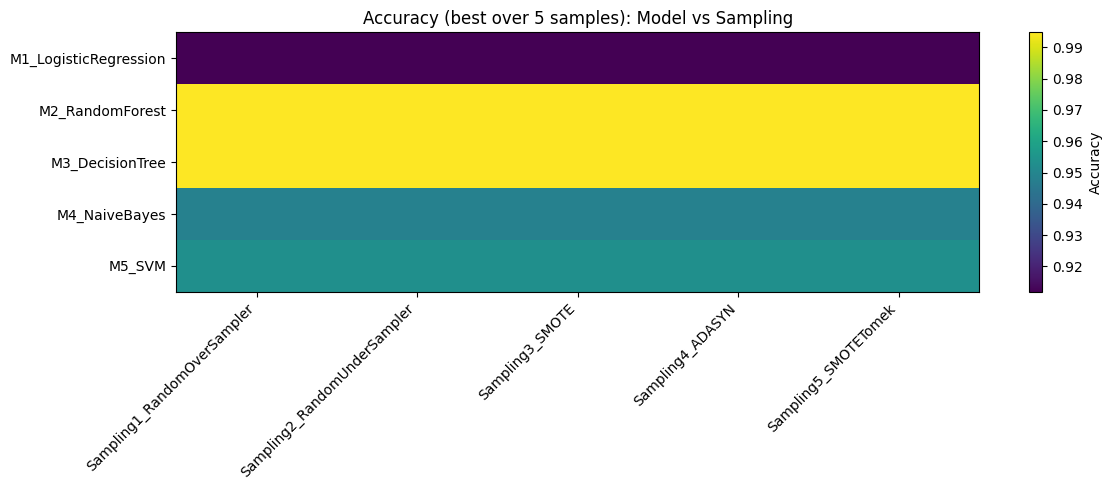

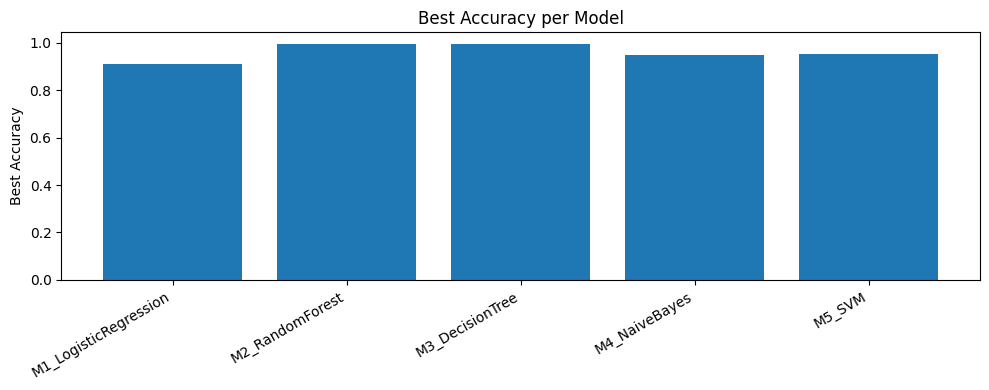

Saved: final_accuracy_table.csv, best_sampling_per_model.csv, accuracy_heatmap.png, best_accuracy_per_model.png


SamplingTechnique,Sampling1_RandomOverSampler,Sampling2_RandomUnderSampler,Sampling3_SMOTE,Sampling4_ADASYN,Sampling5_SMOTETomek
Model,,,,,
M1_LogisticRegression,0.911917,0.911917,0.911917,0.911917,0.911917
M2_RandomForest,0.994819,0.994819,0.994819,0.994819,0.994819
M3_DecisionTree,0.994819,0.994819,0.994819,0.994819,0.994819
M4_NaiveBayes,0.948187,0.948187,0.948187,0.948187,0.948187
M5_SVM,0.953368,0.953368,0.953368,0.953368,0.953368


,BestSamplingTechnique,BestAccuracy
Model,,
M1_LogisticRegression,Sampling1_RandomOverSampler,0.911917
M2_RandomForest,Sampling1_RandomOverSampler,0.994819
M3_DecisionTree,Sampling1_RandomOverSampler,0.994819
M4_NaiveBayes,Sampling1_RandomOverSampler,0.948187
M5_SVM,Sampling1_RandomOverSampler,0.953368


In [9]:
plt.figure(figsize=(12,5))
plt.imshow(final_table.values,aspect="auto")
plt.xticks(range(len(final_table.columns)),final_table.columns,rotation=45,ha="right")
plt.yticks(range(len(final_table.index)),final_table.index)
plt.colorbar(label="Accuracy")
plt.title("Accuracy (best over 5 samples): Model vs Sampling")
plt.tight_layout()
plt.savefig("accuracy_heatmap.png",dpi=200)
plt.show()

plt.figure(figsize=(10,4))
plt.bar(range(len(summary)),summary["BestAccuracy"].values)
plt.xticks(range(len(summary)),summary.index,rotation=30,ha="right")
plt.ylabel("Best Accuracy")
plt.title("Best Accuracy per Model")
plt.tight_layout()
plt.savefig("best_accuracy_per_model.png",dpi=200)
plt.show()

print("Saved: final_accuracy_table.csv, best_sampling_per_model.csv, accuracy_heatmap.png, best_accuracy_per_model.png")
display(final_table)
display(summary)